In [50]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib
import optuna

In [24]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [25]:
%config InlineBackend.figure_format='retina'

In [26]:
DEVICE = utils.find_device(force_cpu=False)

Using device cuda


In [27]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [28]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [29]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Sampling trajectories and evaluating them...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Sampling trajectories and evaluating them...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


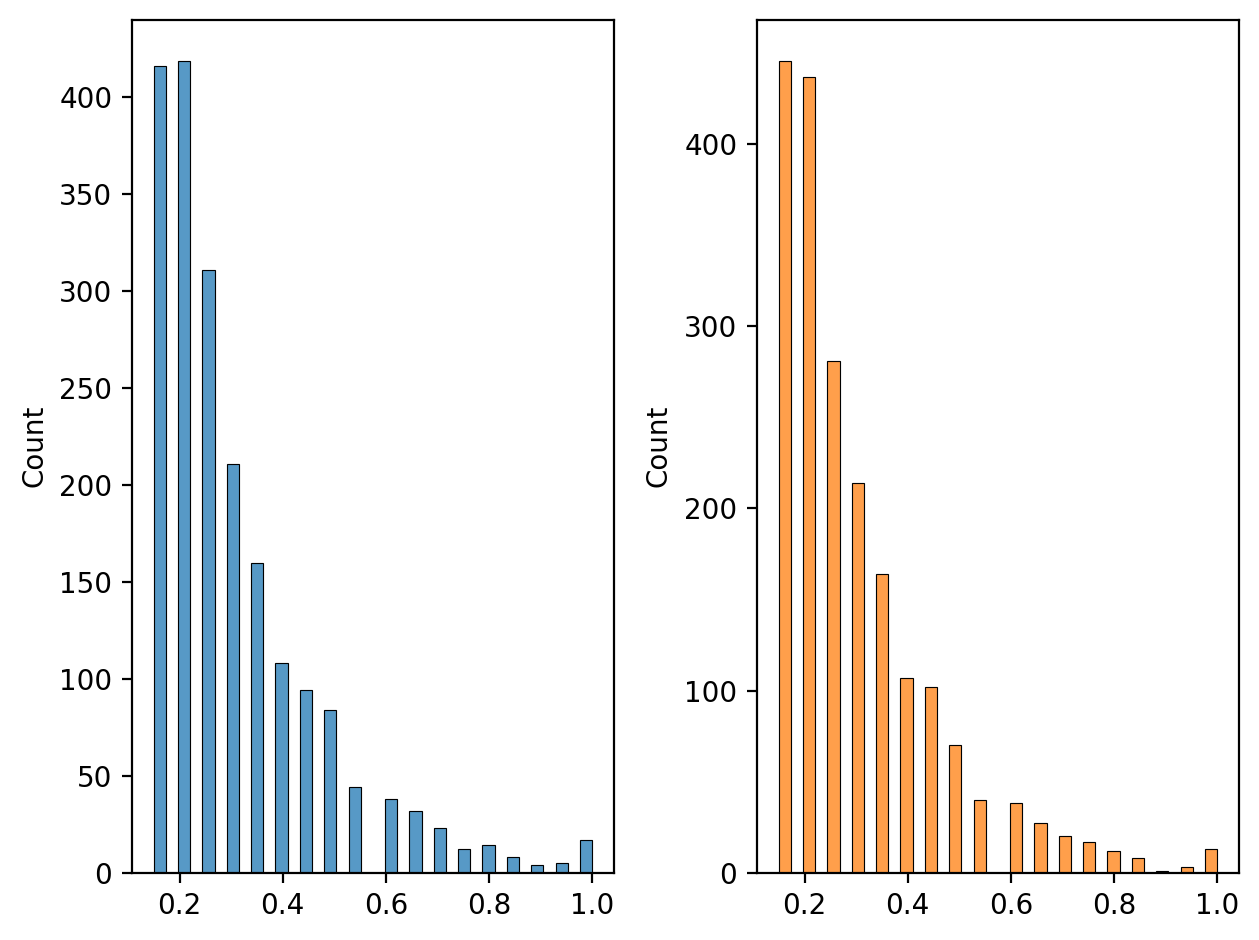

In [30]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# AE

In [36]:
rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [37]:
output.shape

torch.Size([5, 3, 20])

In [38]:
hn.shape

torch.Size([2, 3, 20])

In [39]:
batch_size = 2
train_loader = DataLoader(dataset=train_dataset, batch_size=64)
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.unsqueeze(-1).shape)
    break

torch.Size([64, 20, 1])


## Defining the AE model

In [40]:
class AE(nn.Module):
    # https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/autoencoder/textrnnvae.py
    def __init__(self, time_horizon, z_dim, device, hidden_dim, num_layers):
        super().__init__()
        
        # References
        self.num_layers, self.hidden_dim, self.device = num_layers, hidden_dim, device
        self.time_horizon = time_horizon

        # For encoder
        self.enc = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True)
        
        self.enc_linear = nn.Linear(hidden_dim*num_layers, z_dim)
        # self.mu = nn.Linear(hidden_dim*num_layers, z_dim)
        # self.logvar = nn.Linear(hidden_dim*num_layers, z_dim)

        # For decoder 
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim*num_layers)
        self.out_to_seq = nn.Linear(hidden_dim, 1)
        
        self.dec = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True)
        
    def encode(self, x):
        x = x.unsqueeze(-1)
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device) 
        out, h = self.enc(x, h0)
        # (num_layers*num_directions, batch_size, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers*hidden_dim)
        h = h.transpose(0, 1).contiguous().view(batch_size, -1)
        
        z = self.enc_linear(h)
        # mu = self.mu(h)
        # logvar = self.logvar(h)
        return z # mu , logvar

    #def reparameterize(self, mu, logvar):
    #    std = torch.exp(0.5*logvar)
    #    eps = torch.randn_like(std)
    #    return mu + eps*std

    def decode(self, z):
        batch_size = z.shape[0]
        h = self.z_to_hidden(z)

        # (batch_size, num_directions*num_layers*hidden_dim)    ==>
        # (batch_size, num_directions * num_layers, hidden_dim) ==>
        # (num_layers * num_directions, batch_size, hidden_dim) ==>
        h = h.view(batch_size, self.num_layers, self.hidden_dim).transpose(0, 1).contiguous()
        input = torch.ones(batch_size, 1, 1).to(self.device)
        x = torch.empty((batch_size, self.time_horizon)).to(self.device)
        for step in range(self.time_horizon):
            out, h = self.dec(input, h)
            xi = torch.sigmoid(self.out_to_seq(out.squeeze()).squeeze())
            x[:, step] = xi
        return torch.flip(x, [-1])

    def forward(self, x):
        # mu, logvar = self.encode(x)
        # z = self.reparameterize(mu, logvar)
        z = self.encode(x)
        return self.decode(z) # self.decode(z), mu, logvar

## Define z dimensionality

In [41]:
Z_DIM = 2

## Try the model out

In [43]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
ae = AE(time_horizon=TIME_HORIZON, 
        z_dim=Z_DIM, 
        hidden_dim=500,
        num_layers=2,
        device=DEVICE).to(DEVICE)
for batch_idx, (x, y) in enumerate(train_loader):
    x_rec = ae.decode(ae.encode(x))
    break

## Training AE

In [19]:
def eval_reconstruction(model, data_loader):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            recon_x = model(x)
            delta += torch.abs(x - recon_x).sum()

    n = len(data_loader.dataset)
    delta /= (n*model.time_horizon)
    print(f"Avg reconstruction error: {delta.item():.4f}")    

### Random level for reconstruction

In [20]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.4f} +/- {delta.std().item():.4f}")

Avg reconstruction error: 0.3330 +/- 0.2356


### Initial level of reconstruction error

In [21]:
seed = 1234
torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, z_dim=size_z, device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2856
Avg reconstruction error: 0.2834


### Training loop

In [44]:
seed = 1234
size_z = 2
lr = 0.001
batch_size = len(train_dataset.y)
n_epoch = 5000

torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, 
        hidden_dim=500, num_layers=3,
        z_dim=size_z, 
        device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

optimizer = optim.Adam(list(ae.parameters()), lr=lr) # + list(reg.parameters()), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        epoch_loss = 0 
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()
            recon_x = ae(x)
            loss = nn.L1Loss(reduction="mean")(target=x, input=recon_x)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        hist_loss.append(epoch_loss/len(train_loader))

        pbar.update()
        pbar.set_postfix(loss=f"{hist_loss[-1]:.5f}")

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2505
Avg reconstruction error: 0.2505


  0%|          | 0/5000 [00:00<?, ?it/s]

Avg reconstruction error: 0.0157
Avg reconstruction error: 0.2893


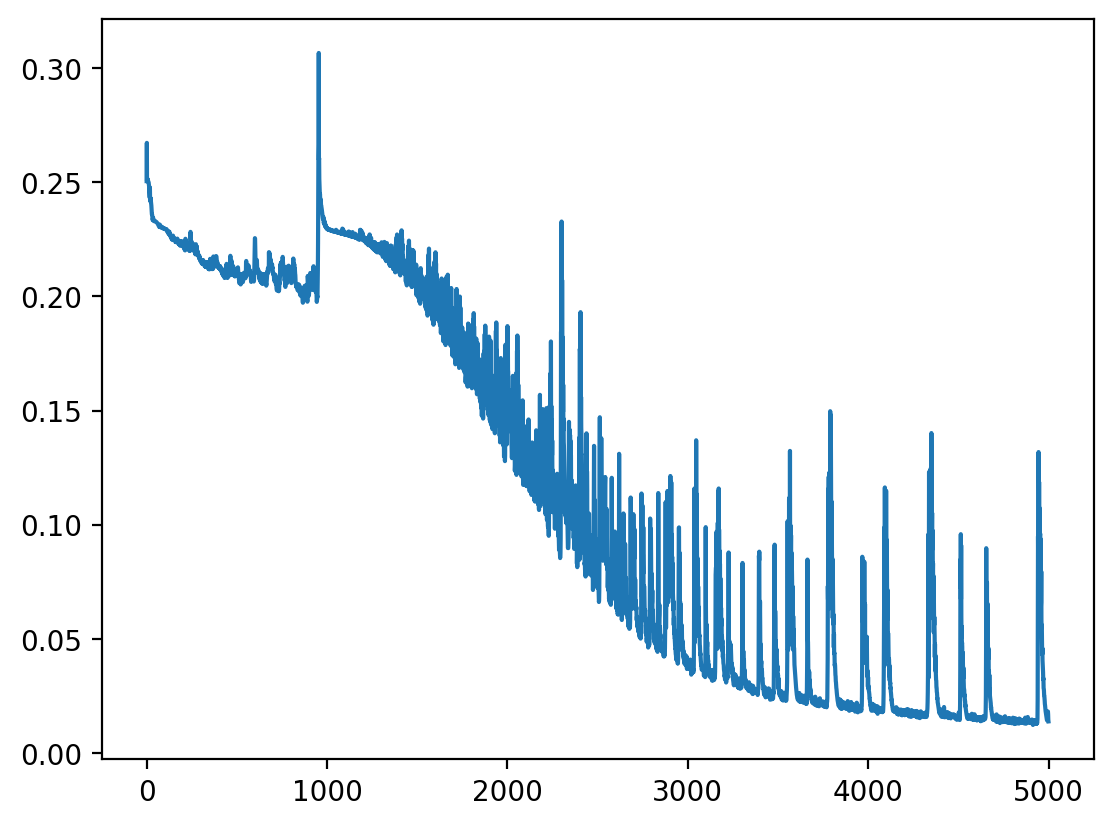

In [45]:
plt.plot(hist_loss)

In [47]:
eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.0157
Avg reconstruction error: 0.2893


## Visualize structuration of the latent space

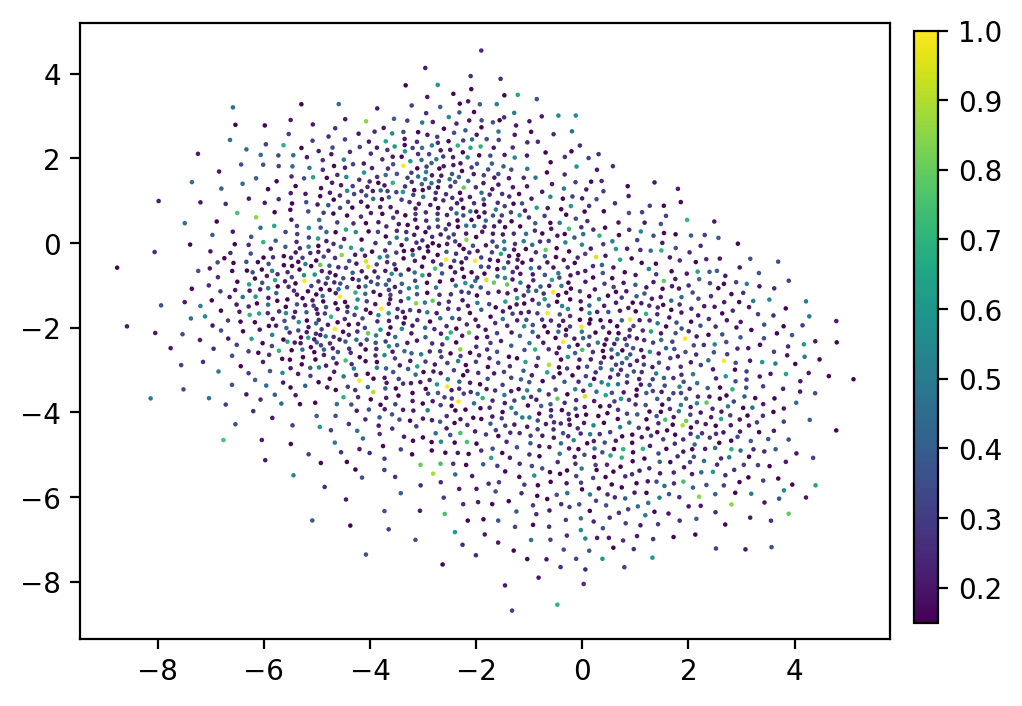

In [49]:
ae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    z = ae.encode(x)
    z = z.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));